<a href="https://colab.research.google.com/github/JorgeJaramilo060892/Machine-Learning-first-steps/blob/main/Logistic_Reg_Clas_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Customer churn with Logistic Regression
A telecommunications company is concerned about the number of customers leaving their land-line business for cable competitors. They need to understand who is leaving. Imagine that you are an analyst at this company and you have to find out who is leaving and why.
<h2 id="about_dataset">About the dataset</h2>
We will use a telecommunications dataset for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically it is less expensive to keep customers than acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.


This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.



The dataset includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they had been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:

!wget -O ChurnData.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv

--2023-11-03 19:38:35--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35943 (35K) [text/csv]
Saving to: ‘ChurnData.csv’

ChurnData.csv       100%[===================>]  35.10K  --.-KB/s    in 0.02s   

2023-11-03 19:38:36 (2.21 MB/s) - ‘ChurnData.csv’ saved [35943/35943]



In [12]:
churn_df = pd.read_csv("ChurnData.csv")
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


<h2 id="preprocessing">Data pre-processing and selection</h2>
Let's select some features for the modeling. Also, we change the target data type to be an integer, as it is a requirement by the skitlearn algorithm:


In [13]:
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

<ipython-input-13-044f3f307695>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_df['churn'] = churn_df['churn'].astype('int')


,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


In [9]:
churn_df.shape

(200, 9)

In [14]:
# Let's define X, and y for our dataset
X = np.asarray(churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']])
X[0:5]

array([[ 11.,  33.,   7., 136.,   5.,   5.,   0.],
       [ 33.,  33.,  12.,  33.,   2.,   0.,   0.],
       [ 23.,  30.,   9.,  30.,   1.,   2.,   0.],
       [ 38.,  35.,   5.,  76.,   2.,  10.,   1.],
       [  7.,  35.,  14.,  80.,   2.,  15.,   0.]])

In [15]:
y = np.asarray(churn_df['churn'])
y[0:5]

array([1, 1, 0, 0, 0])

## Train/Test dataset
We split our dataset into train and test set:

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print("Train Set:", X_train.shape, y_train.shape)
print("Test Set:",X_test.shape, y_test.shape)

Train Set: (160, 7) (160,)
Test Set: (40, 7) (40,)


<h2 id="modeling">Modeling (Logistic Regression with Scikit-learn)</h2>
Let's build our model using __LogisticRegression__ from the Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in the internet.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem of machine learning models.
__C__ parameter indicates __inverse of regularization strength__ which must be a positive float. Smaller values specify stronger regularization.
Now let's fit our model with train set:


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver="liblinear").fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [18]:
# Now we can predict using our test set
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

__predict_proba__  returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X):

In [19]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.85690857, 0.14309143],
       [0.8697156 , 0.1302844 ],
       [0.76166698, 0.23833302],
       [0.90407428, 0.09592572],
       [0.73013344, 0.26986656],
       [0.51687948, 0.48312052],
       [0.62528805, 0.37471195],
       [0.87343004, 0.12656996],
       [0.41738015, 0.58261985],
       [0.90879227, 0.09120773],
       [0.91197227, 0.08802773],
       [0.94638922, 0.05361078],
       [0.46056268, 0.53943732],
       [0.50728319, 0.49271681],
       [0.85969108, 0.14030892],
       [0.83853006, 0.16146994],
       [0.69422555, 0.30577445],
       [0.83555304, 0.16444696],
       [0.76818077, 0.23181923],
       [0.63304223, 0.36695777],
       [0.86342114, 0.13657886],
       [0.6537177 , 0.3462823 ],
       [0.93254727, 0.06745273],
       [0.5620099 , 0.4379901 ],
       [0.796927  , 0.203073  ],
       [0.95143725, 0.04856275],
       [0.77561377, 0.22438623],
       [0.80906014, 0.19093986],
       [0.59530665, 0.40469335],
       [0.96431506, 0.03568494],
       [0.

<h2 id="evaluation">Evaluation</h2>


###jaccard index
Let's try the jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by the size of the union of the two label sets. If the entire set of predicted labels for a sample strictly matches with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

In [20]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat, pos_label=0)

0.6486486486486487

### confusion matrix
Another way of looking at the accuracy of the classifier is to look at __confusion matrix__.

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matriz',
                          cmap=plt.cm.Blues):
  """
  This funcion prints and plots the confusion matrix.
  Normalization can be applied by seting 'normalize=True'.
  """
  if normalize:
    cm = cm.astyple("float") / cm.sum(axis=1) [:, np.newaxis]
    print("Normalized confusion matrix")
  else:
      print("Confusion Matrix, without normalization")

  print(cm)

  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes,rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() /2
  for i, j, in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    (confusion_matrix(y_test, yhat, labels=[1,0]))

Confusion Matrix, without normalization
[[ 3 12]
 [ 1 24]]


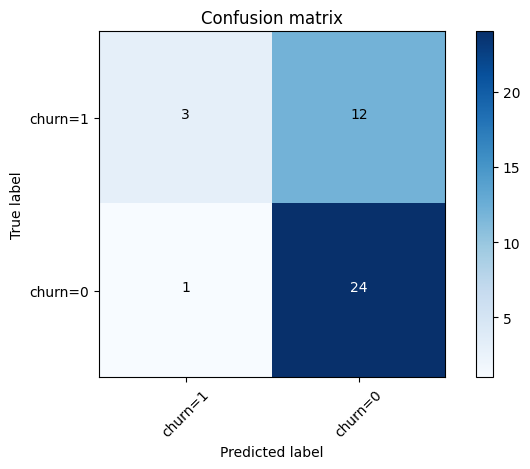

In [26]:
## Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

Let's look at first row. The first row is for customers whose actual churn value in the test set is 1.
As you can calculate, out of 40 customers, the churn value of 15 of them is 1.
Out of these 15 cases, the classifier correctly predicted 6 of them as 1, and 9 of them as 0.

This means, for 6 customers, the actual churn value was 1 in test set and classifier also correctly predicted those as 1. However, while the actual label of 9 customers was 1, the classifier predicted those as 0, which is not very good. We can consider it as the error of the model for first row.

What about the customers with churn value 0? Lets look at the second row.
It looks like  there were 25 customers whom their churn value were 0.


The classifier correctly predicted 24 of them as 0, and one of them wrongly as 1. So, it has done a good job in predicting the customers with churn value 0. A good thing about the confusion matrix is that it shows the model’s ability to correctly predict or separate the classes.  In a specific case of the binary classifier, such as this example,  we can interpret these numbers as the count of true positives, false positives, true negatives, and false negatives.


In [28]:
#[[ TP  FN]
#[ FP  TN]]


- TP (True Positives): Representa los casos en los que el modelo predijo correctamente la clase positiva.
- FN (False Negatives): Representa los casos en los que el modelo predijo incorrectamente la clase negativa cuando en realidad era positiva.
- FP (False Positives): Representa los casos en los que el modelo predijo incorrectamente la clase positiva cuando en realidad era negativa.
- TN (True Negatives): Representa los casos en los que el modelo predijo correctamente la clase negativa.

Esto significa que:

- Hay 3 casos en los que el modelo predijo correctamente la clase positiva (TP).
- Hay 12 casos en los que el modelo predijo incorrectamente la clase negativa cuando en realidad era positiva (FN).
- Hay 1 caso en el que el modelo predijo incorrectamente la clase positiva cuando en realidad era negativa (FP).
- Hay 24 casos en los que el modelo predijo correctamente la clase negativa (TN).


La frase "Confusion Matrix, without normalization" indica que esta es la matriz de confusión sin aplicar normalización. Si se aplica normalización, los números en la matriz se dividen por el total de casos en cada fila, lo que da una visión proporcional de los errores en cada clase.




In [27]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.67      0.96      0.79        25
           1       0.75      0.20      0.32        15

    accuracy                           0.68        40
   macro avg       0.71      0.58      0.55        40
weighted avg       0.70      0.68      0.61        40



Based on the count of each section, we can calculate precision and recall of each label:


- __Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

- __Recall__ is the true positive rate. It is defined as: Recall =  TP / (TP + FN)

    
So, we can calculate the precision and recall of each class.

__F1 score:__
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label.

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.


Finally, we can tell the average accuracy for this classifier is the average of the F1-score for both labels, which is 0.72 in our case.

### log loss
Now, let's try __log loss__ for evaluation. In logistic regression, the output can be the probability of customer churn is yes (or equals to 1). This probability is a value between 0 and 1.
Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1.

In [29]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5633358354733641

Let's try to build Logistic Regression model again for the same dataset, but this time, use different __solver__ and __regularization__ values? What is new __logLoss__ value?

In [30]:
LR2 = LogisticRegression(C=0.01, solver="sag").fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print("LogLoss:, %.2f" % log_loss(y_test, yhat_prob2))

LogLoss:, 0.62


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
